In [1]:
import numpy as np 
import pandas as pd 
import random
import matplotlib.pyplot as plt
import GPy
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor

from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn import preprocessing

from matplotlib import style
style.use('seaborn-white')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
def cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c, mu_p, gravity, force, dt):
    theta_dd = ((m1+m2)*gravity*np.sin(theta)-np.cos(theta)*(force+m2*length*(theta_d**2)*np.sin(theta)-mu_c*x_d)-((m1+m2)*mu_p*theta_d)/(m2*length)) / ((m1+m2)*(k_inertia+1)*length - m2*length*(np.cos(theta))**2)
    x_dd = (force-m2*length*(theta_dd*np.cos(theta)-(theta_d**2)*np.sin(theta))-mu_c*x_d) / (m1+m2)
    # Euler Integrator 
    x_d = x_d + x_dd*dt
    x = x + x_d*dt
    theta_d = theta_d + theta_dd*dt
    theta = theta + theta_d*dt
    return theta_dd, theta_d, theta, x_dd, x_d,  x 

In [3]:
# Uncertainty Sources 
m1 = 1
m2 = 0.1
length = 0.5
k_inertia = 1/3
mu_c = 0.0005
mu_p = 0.000002
gravity = 9.8 
dt = 0.01

# Initialization 
theta = 0.3 # np.random.uniform(low=-0.05, high=0.05)
theta_d = 1 # np.random.uniform(low=-0.05, high=0.05)
x = 0 # np.random.uniform(low=-0.05, high=0.05)
x_d = 0 # np.random.uniform(low=-0.05, high=0.05)

# lists for storing results 
theta_dd_sim = []
theta_d_sim = [theta_d]
theta_sim = [theta]
x_dd_sim = []
x_d_sim = [x_d]
x_sim = [x]

noOfSteps = 12000
ts = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

for i in range(noOfSteps):
    force = -0.2+0.5*np.sin(6*ts[i])
    #force = -1+np.sin(ts[i])+3*np.sin(2*ts[i])
    #force = -0.5+0.2*np.sin(ts[i])+0.3*np.sin(2*ts[i])
    theta_dd, theta_d, theta, x_dd, x_d, x = cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c, mu_p, gravity, force, dt)
    theta_dd_sim.append(theta_dd)
    theta_d_sim.append(theta_d)
    theta_sim.append(theta)
    x_dd_sim.append(x_dd)
    x_d_sim.append(x_d)
    x_sim.append(x)

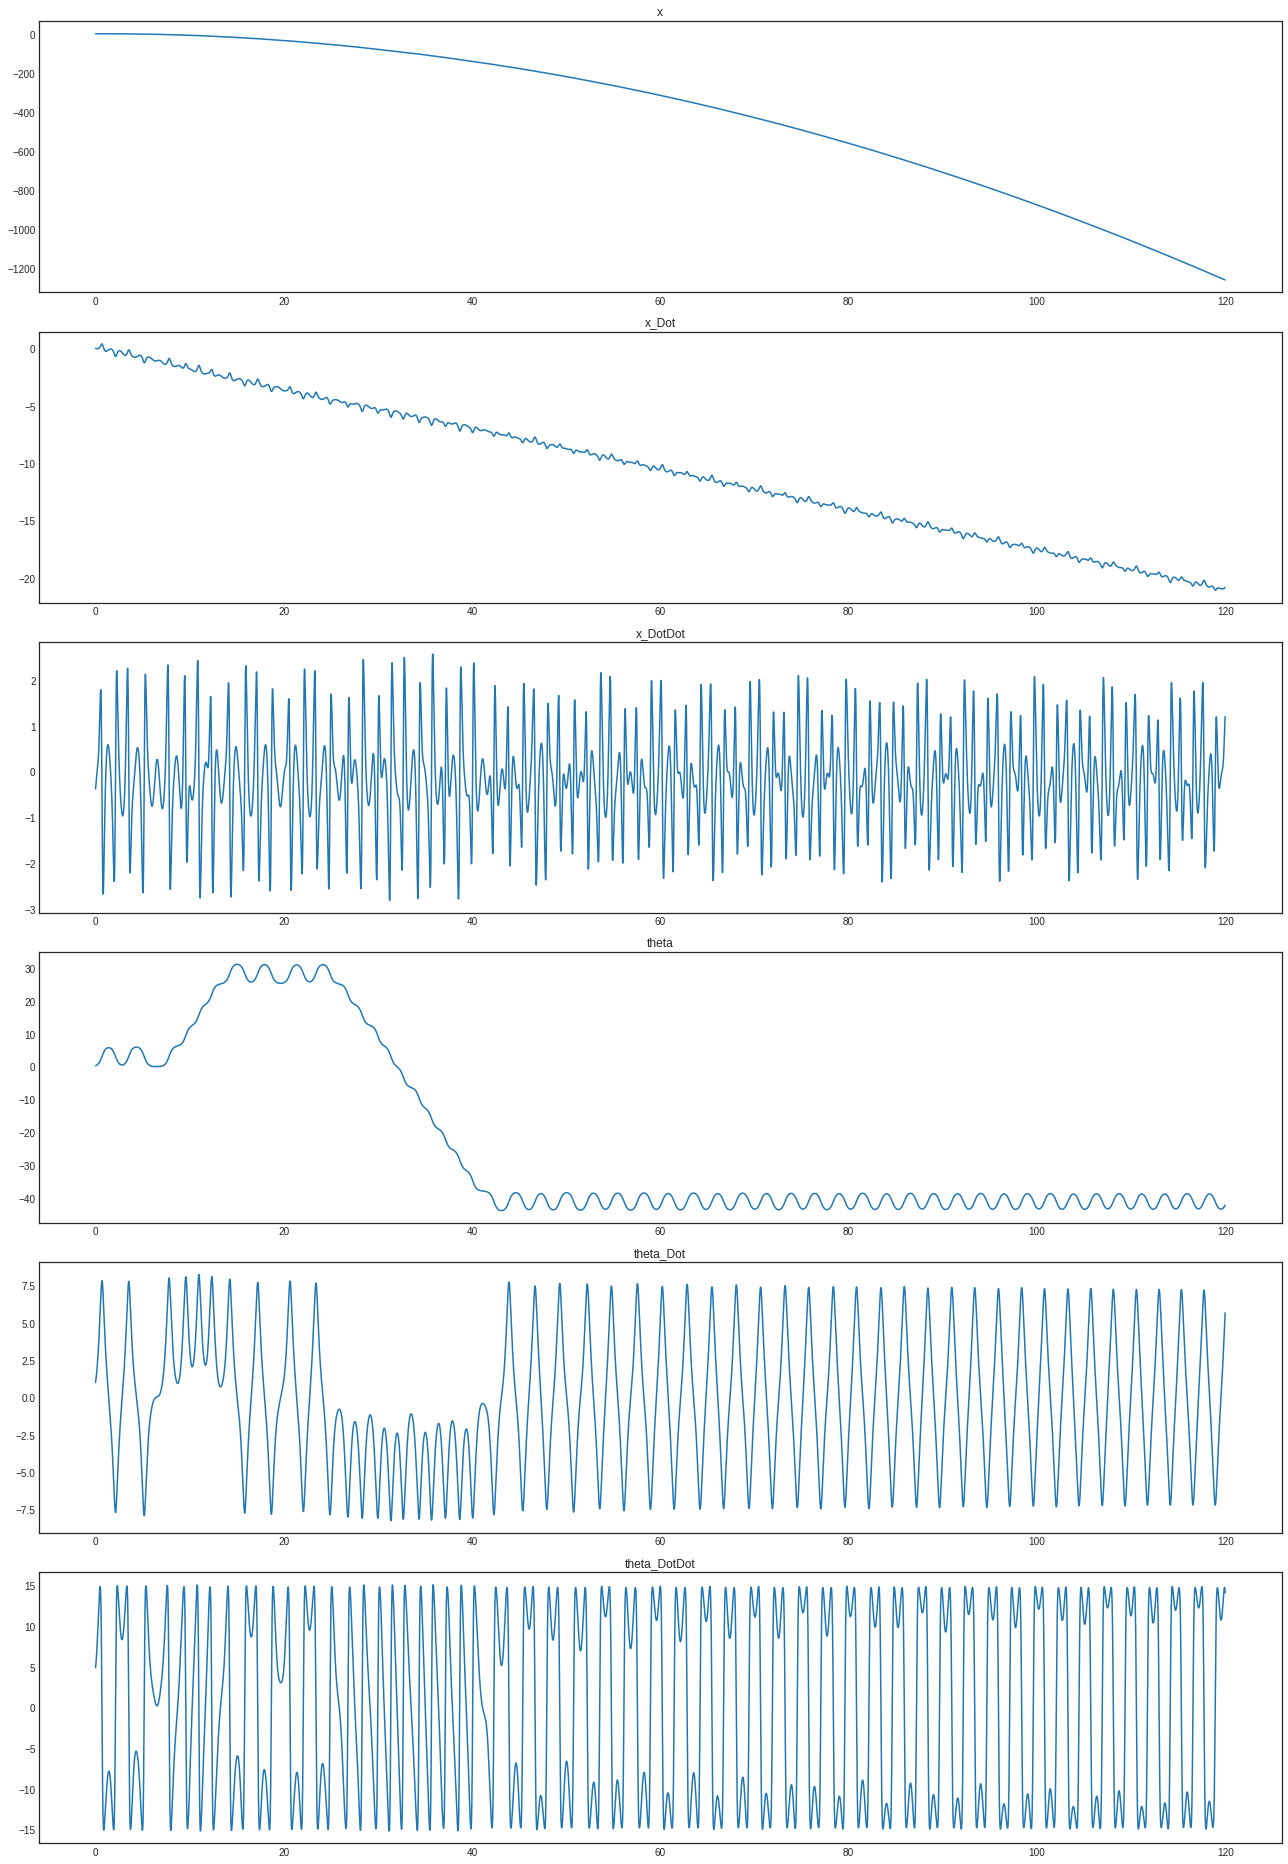

In [4]:
# Converting to Numpy Arrays for Plotting
theta_dd_sim = np.array(theta_dd_sim)
theta_d_sim = np.array(theta_d_sim)
theta_sim = np.array(theta_sim)
x_dd_sim = np.array(x_dd_sim)
x_d_sim = np.array(x_d_sim)
x_sim = np.array(x_sim)

timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

startTraj = 0
endTraj = 12000

# Plotting 
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6)

fig.set_figheight(26)
fig.set_figwidth(18)

ax1.plot(timeSteps[startTraj:endTraj], x_sim[startTraj:endTraj])
ax1.set_title("x")
ax2.plot(timeSteps[startTraj:endTraj], x_d_sim[startTraj:endTraj])
ax2.set_title("x_Dot")
ax3.plot(timeSteps[startTraj:endTraj], x_dd_sim[startTraj:endTraj])
ax3.set_title("x_DotDot")
#axs[1, 0].sharex(axs[0, 0])
ax4.plot(timeSteps[startTraj:endTraj], theta_sim[startTraj:endTraj])
ax4.set_title("theta")
ax5.plot(timeSteps[startTraj:endTraj], theta_d_sim[startTraj:endTraj])
ax5.set_title("theta_Dot")
ax6.plot(timeSteps[startTraj:endTraj], theta_dd_sim[startTraj:endTraj])
ax6.set_title("theta_DotDot")
fig.tight_layout()

Text(0.5, 1.0, 'A single plot')

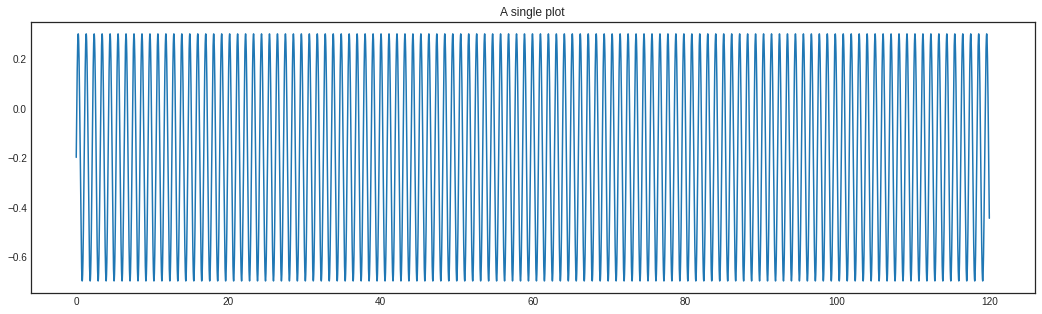

In [5]:
# Force Input Plot 
forceIn = -0.2+0.5*np.sin(6*timeSteps)
fig, ax = plt.subplots()

fig.set_figheight(5)
fig.set_figwidth(18)

ax.plot(timeSteps[startTraj:endTraj], forceIn[startTraj:endTraj])
ax.set_title('A single plot')

# GPy

In [6]:
st_Traj = 0
en_Traj = 8000 # 2307 # 9405

# Training Input (Standardized)
theta_sim_mean = theta_sim[st_Traj:en_Traj].mean()
theta_sim_stdev = theta_sim[st_Traj:en_Traj].std()

theta_d_sim_mean = theta_d_sim[st_Traj:en_Traj].mean()
theta_d_sim_stdev = theta_d_sim[st_Traj:en_Traj].std()

x_d_sim_mean = x_d_sim[st_Traj:en_Traj].mean()
x_d_sim_stdev = x_d_sim[st_Traj:en_Traj].std()

forceIn_mean = forceIn[st_Traj:en_Traj].mean()
forceIn_stdev = forceIn[st_Traj:en_Traj].std()  

# Training Output (Standardized)
theta_dd_sim_mean = theta_dd_sim[st_Traj:en_Traj].mean()
theta_dd_sim_stdev = theta_dd_sim[st_Traj:en_Traj].std()  

x_dd_sim_mean = x_dd_sim[st_Traj:en_Traj].mean()
x_dd_sim_stdev = x_dd_sim[st_Traj:en_Traj].std() 

X_train = np.stack(((theta_sim[st_Traj:en_Traj]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[st_Traj:en_Traj]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[st_Traj:en_Traj]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[st_Traj:en_Traj]-forceIn_mean)/forceIn_stdev), axis=1)

Y_train_theta = ((theta_dd_sim[st_Traj:en_Traj]-theta_dd_sim_mean)/theta_dd_sim_stdev).reshape(-1,1)  # RMSE(A)
Y_train_x = ((x_dd_sim[st_Traj:en_Traj]-x_dd_sim_mean)/x_dd_sim_stdev).reshape(-1,1)  # RMSE(V)

# Testing Output (Standardized)

Y_test_theta = ((theta_dd_sim[en_Traj:]-theta_dd_sim_mean)/theta_dd_sim_stdev).reshape(-1,1)  # RMSE(A)
Y_test_x = ((x_dd_sim[en_Traj:]-x_dd_sim_mean)/x_dd_sim_stdev).reshape(-1,1)  # RMSE(V)

X_prior = np.stack(((theta_sim[:-1]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[:-1]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[:-1]-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev), axis=1) # Prior

In [7]:
def train_out(Y_train):    
    noise = 0.017

    #k1 = GPy.kern.ExpQuad(input_dim=3)
    #k2 = GPy.kern.Exponential(input_dim=3)

    #myKernel = k1*k2
    myKernel = GPy.kern.RatQuad(input_dim=4, ARD=True)
    gpr = GPy.models.GPRegression(X_train, Y_train, kernel=myKernel)

    # Fix the noise variance to known value 
    gpr.Gaussian_noise.variance = noise**2
    gpr.Gaussian_noise.variance.fix()

    # Run optimization
    gpr.optimize()

    # Display optimized parameter values
    display(gpr)
    return gpr

In [8]:
#pool = mp.Pool(mp.cpu_count())
#gpr_th, gpr_x = pool.map(train_out, [Y_train_theta, Y_train_x])
#pool.close()

In [9]:
gpr_th = train_out(Y_train_theta)
gpr_x = train_out(Y_train_x)

GP_regression.,value,constraints,priors
RatQuad.variance,1.0643528973039715,+ve,
RatQuad.lengthscale,"(4,)",+ve,
RatQuad.power,154.5454362163624,+ve,
Gaussian_noise.variance,0.00028900000000000003,+ve fixed,


GP_regression.,value,constraints,priors
RatQuad.variance,7746.102607215463,+ve,
RatQuad.lengthscale,"(4,)",+ve,
RatQuad.power,0.042369078757605615,+ve,
Gaussian_noise.variance,0.00028900000000000003,+ve fixed,


In [10]:
mu_theta, cov_theta = gpr_th.predict(X_prior)
#np.save('GP_RatQuad_Theta.npy', gpr_th.param_array)

mu_x, cov_x = gpr_x.predict(X_prior)
#np.save('GP_RatQuad_x.npy', gpr_x.param_array)

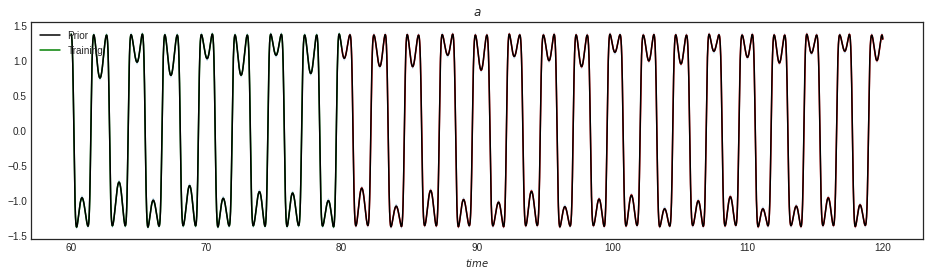

In [15]:
mu = mu_theta.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov_theta))

start_Traj = 6000
end_Traj = 12000
train_test_split = 8000

fig, ax = plt.subplots(1) 

fig.set_figheight(4)
fig.set_figwidth(16)

ax.fill_between(timeSteps[start_Traj:end_Traj], mu[start_Traj:end_Traj] + uncertainty, mu[start_Traj:end_Traj] - uncertainty, alpha=0.3)
p1, = ax.plot(timeSteps[start_Traj:train_test_split], Y_train_theta[start_Traj:], 'g')
ax.plot(timeSteps[train_test_split:end_Traj], Y_test_theta[:end_Traj-train_test_split], 'r')
g1, = ax.plot(timeSteps[start_Traj:end_Traj], mu[start_Traj:end_Traj], 'k')
ax.set_title('$a$')
ax.legend((g1, p1), ('Prior', 'Training'), loc='upper left', shadow=False)
plt.xlabel("$time$")
#plt.savefig('ResearchUpdate#40/veryGoodModel1.png')
plt.show()

Text(0.5, 0, '$time$')

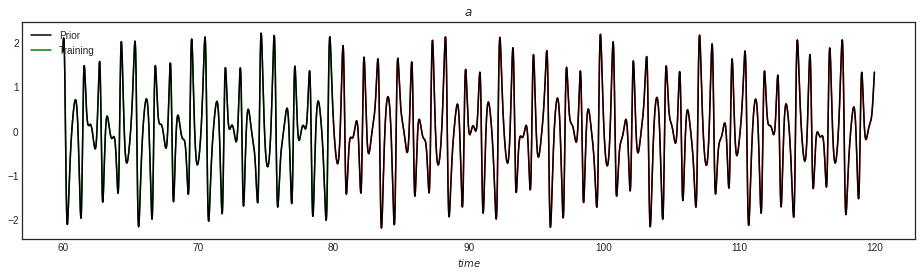

In [16]:
mu = mu_x.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov_x))

start_Traj = 6000
end_Traj = 12000
train_test_split = 8000

fig, ax = plt.subplots(1) 

fig.set_figheight(4)
fig.set_figwidth(16)

ax.fill_between(timeSteps[start_Traj:end_Traj], mu[start_Traj:end_Traj] + uncertainty, mu[start_Traj:end_Traj] - uncertainty, alpha=0.3)
p1, = ax.plot(timeSteps[start_Traj:train_test_split], Y_train_x[start_Traj:], 'g')
ax.plot(timeSteps[train_test_split:end_Traj], Y_test_x[:end_Traj-train_test_split], 'r')
g1, = ax.plot(timeSteps[start_Traj:end_Traj], mu[start_Traj:end_Traj], 'k')
ax.set_title('$a$')
ax.legend((g1, p1), ('Prior', 'Training'), loc='upper left', shadow=False)
plt.xlabel("$time$")
#plt.savefig('ResearchUpdate#40/veryGoodModel1.png')

# RMSE(theta_dd)

In [7]:
# Model creation, without initialization:
#k1 = GPy.kern.ExpQuad(input_dim=3)
#k2 = GPy.kern.Exponential(input_dim=3)
myKernel = GPy.kern.RatQuad(input_dim=4, ARD=True)
#myKernel = k1+k2
load_gpr_th = GPy.models.GPRegression(X_train, Y_train_theta, kernel=myKernel, initialize=False)
load_gpr_th.update_model(False) # do not call the underlying expensive algebra on load
load_gpr_th.initialize_parameter() # Initialize the parameters (connect the parameters up)
load_gpr_th[:] = np.load('../../learnedModels/deterministicCase/GPwithGPy/GP_RatQuad_Theta.npy') # Load the parameters
load_gpr_th.update_model(True) # Call the algebra only once
print(load_gpr_th)


Name : GP regression
Objective : -24443.5089288535
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  RatQuad.variance         |      1.0643528973039715  |      +ve      |        
  RatQuad.lengthscale      |                    (4,)  |      +ve      |        
  RatQuad.power            |       154.5454362163624  |      +ve      |        
  Gaussian_noise.variance  |  0.00028900000000000003  |      +ve      |        


In [8]:
# Model creation, without initialization:
#k1 = GPy.kern.ExpQuad(input_dim=3)
#k2 = GPy.kern.Exponential(input_dim=3)
myKernel = GPy.kern.RatQuad(input_dim=4, ARD=True)
#myKernel = k1+k2
load_gpr_x = GPy.models.GPRegression(X_train, Y_train_x, kernel=myKernel, initialize=False)
load_gpr_x.update_model(False) # do not call the underlying expensive algebra on load
load_gpr_x.initialize_parameter() # Initialize the parameters (connect the parameters up)
load_gpr_x[:] = np.load('../../learnedModels/deterministicCase/GPwithGPy/GP_RatQuad_x.npy') # Load the parameters
load_gpr_x.update_model(True) # Call the algebra only once
print(load_gpr_x)


Name : GP regression
Objective : -24000.86006954033
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  RatQuad.variance         |       7746.102607215463  |      +ve      |        
  RatQuad.lengthscale      |                    (4,)  |      +ve      |        
  RatQuad.power            |    0.042369078757605615  |      +ve      |        
  Gaussian_noise.variance  |  0.00028900000000000003  |      +ve      |        


In [12]:
trunc_st = 0
trunc_en = 9000

X_prior = np.stack(((theta_sim[trunc_st:trunc_en]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[trunc_st:trunc_en]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[trunc_st:trunc_en]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[trunc_st:trunc_en]-forceIn_mean)/forceIn_stdev), axis=1)
#X_prior = np.stack(((theta_sim[:-1]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[:-1]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[:-1]-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev), axis=1) # Prior

In [13]:
mu_th_dd = np.zeros(X_prior.shape[0])
cov_th_dd = np.zeros((X_prior.shape[0], X_prior.shape[0]))
gp_th_d = np.zeros(X_prior.shape[0])
gp_th = np.zeros(X_prior.shape[0])

mu_x_dd = np.zeros(X_prior.shape[0])
cov_x_dd = np.zeros((X_prior.shape[0], X_prior.shape[0]))
gp_x_d = np.zeros(X_prior.shape[0])
gp_x = np.zeros(X_prior.shape[0])

mu_th_dd[0] =  theta_dd_sim[trunc_st]
gp_th_d[0] = theta_d_sim[trunc_st]
gp_th[0] = theta_sim[trunc_st]
mu_x_dd[0] = x_dd_sim[trunc_st]
gp_x_d[0] = x_d_sim[trunc_st]
gp_x[0] = x_sim[trunc_st]

for k in range(X_prior.shape[0]):
    if k != X_prior.shape[0]-1:
        mu_th_dd[k+1], cov_th_dd[k+1,:] = load_gpr_th.predict(X_prior[k,:].reshape(1,-1))
        unstand_acc = mu_th_dd[k+1]*theta_dd_sim_stdev + theta_dd_sim_mean
        gp_th_d[k+1] = gp_th_d[k]+(unstand_acc)*(dt)
        #X_prior[k+1,1] = (gp_th_d[k+1]-theta_d_sim_mean) / theta_d_sim_stdev
        gp_th[k+1] = gp_th[k] + (gp_th_d[k+1] + gp_th_d[k])*(dt) / 2 #+ (0.5)*(mu_s[k])*(dt**2)
        #X_prior[k+1,0] = (gp_th[k+1]-theta_sim_mean) / theta_sim_stdev
        mu_x_dd[k+1], cov_x_dd[k+1,:] = load_gpr_x.predict(X_prior[k,:].reshape(1,-1))
        unstand_x = mu_x_dd[k+1]*x_dd_sim_stdev + x_dd_sim_mean
        gp_x_d[k+1] = gp_x_d[k]+(unstand_x)*(dt)
        #X_prior[k+1,2] = (gp_x_d[k+1]-x_d_sim_mean) / x_d_sim_stdev
        gp_x[k+1] = gp_x[k] + (gp_x_d[k+1] + gp_x_d[k])*(dt) / 2 #+ (0.5)*(mu_s[k])*(dt**2)

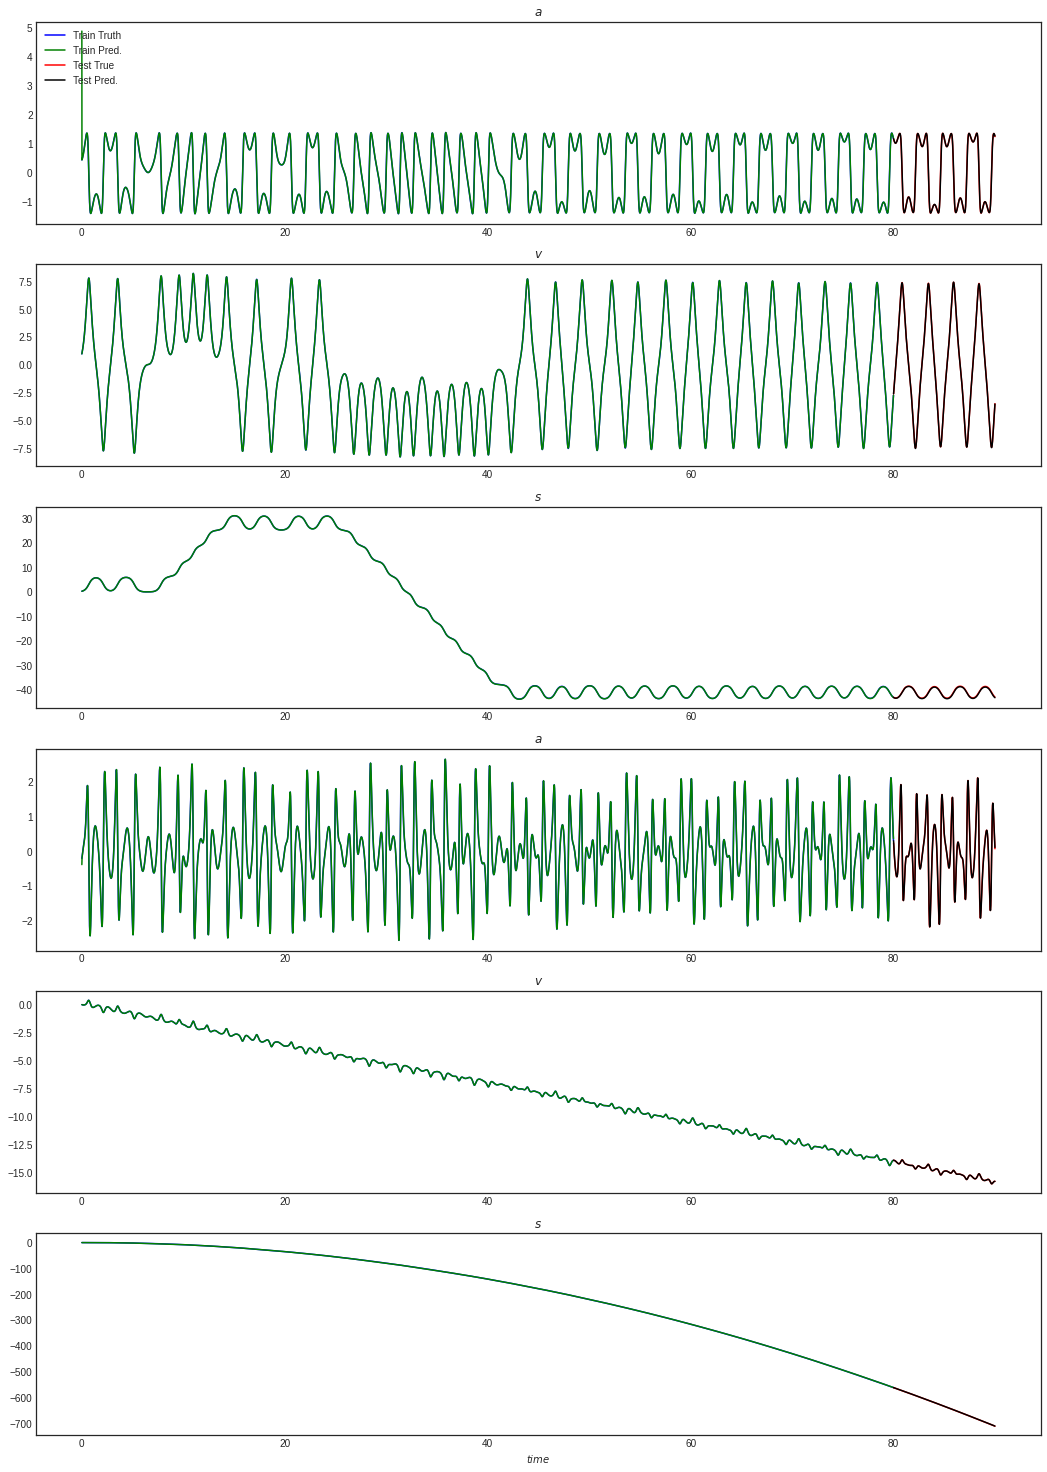

In [14]:
# Plotting 
train_test_split = 8000 # define it above later on 

st_Trajec = trunc_st
mid_Trajec = train_test_split
en_Trajec = trunc_en

# For predictions
mid_pred = train_test_split - trunc_st 

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6) 

fig.set_figheight(26)
fig.set_figwidth(18)

uncertainty_th = 1.96 * np.sqrt(np.diag(cov_th_dd))
uncertainty_x = 1.96 * np.sqrt(np.diag(cov_x_dd))

ax1.fill_between(timeSteps[st_Trajec:en_Trajec], mu_th_dd + uncertainty_th, mu_th_dd - uncertainty_th, alpha=0.3)
b1, = ax1.plot(timeSteps[st_Trajec:mid_Trajec], Y_train_theta[st_Trajec:mid_Trajec], "b")
g1, = ax1.plot(timeSteps[st_Trajec:mid_Trajec], mu_th_dd[:mid_pred], "g")
r1, = ax1.plot(timeSteps[mid_Trajec:en_Trajec], Y_test_theta[:en_Trajec-mid_Trajec], "r")
k1, = ax1.plot(timeSteps[mid_Trajec:en_Trajec], mu_th_dd[mid_pred:], "k")
ax1.set_title('$a$')

ax2.plot(timeSteps[st_Trajec:mid_Trajec], theta_d_sim[st_Trajec:mid_Trajec], "b")
ax2.plot(timeSteps[st_Trajec:mid_Trajec], gp_th_d[:mid_pred], "g")
ax2.plot(timeSteps[mid_Trajec:en_Trajec], theta_d_sim[mid_Trajec:en_Trajec], "r")
ax2.plot(timeSteps[mid_Trajec:en_Trajec], gp_th_d[mid_pred:], "k")
ax2.set_title('$v$')

ax3.plot(timeSteps[st_Trajec:mid_Trajec], theta_sim[st_Trajec:mid_Trajec], "b")
ax3.plot(timeSteps[st_Trajec:mid_Trajec], gp_th[:mid_pred], "g")
ax3.plot(timeSteps[mid_Trajec:en_Trajec], theta_sim[mid_Trajec:en_Trajec], "r")
ax3.plot(timeSteps[mid_Trajec:en_Trajec], gp_th[mid_pred:], "k")
ax3.set_title('$s$')

ax4.fill_between(timeSteps[st_Trajec:en_Trajec], mu_x_dd + uncertainty_x, mu_x_dd - uncertainty_x, alpha=0.3)
ax4.plot(timeSteps[st_Trajec:mid_Trajec], Y_train_x[st_Trajec:], "b")
ax4.plot(timeSteps[st_Trajec:mid_Trajec], mu_x_dd[:mid_pred], "g")
ax4.plot(timeSteps[mid_Trajec:en_Trajec], Y_test_x[:en_Trajec-mid_Trajec], "r")
ax4.plot(timeSteps[mid_Trajec:en_Trajec], mu_x_dd[mid_pred:], "k")
ax4.set_title('$a$')

ax5.plot(timeSteps[st_Trajec:mid_Trajec], x_d_sim[st_Trajec:mid_Trajec], "b")
ax5.plot(timeSteps[st_Trajec:mid_Trajec], gp_x_d[:mid_pred], "g")
ax5.plot(timeSteps[mid_Trajec:en_Trajec], x_d_sim[mid_Trajec:en_Trajec], "r")
ax5.plot(timeSteps[mid_Trajec:en_Trajec], gp_x_d[mid_pred:], "k")
ax5.set_title('$v$')

ax6.plot(timeSteps[st_Trajec:mid_Trajec], x_sim[st_Trajec:mid_Trajec], "b")
ax6.plot(timeSteps[st_Trajec:mid_Trajec], gp_x[:mid_pred], "g")
ax6.plot(timeSteps[mid_Trajec:en_Trajec], x_sim[mid_Trajec:en_Trajec], "r")
ax6.plot(timeSteps[mid_Trajec:en_Trajec], gp_x[mid_pred:], "k")
ax6.set_title('$s$')

ax1.legend((b1, g1, r1, k1), ('Train Truth', 'Train Pred.', 'Test True', 'Test Pred.'), loc='upper left', shadow=False)
plt.xlabel("$time$")
#plt.savefig('GP_Exp_Stand_JIANG(A).png')
plt.show()